# A/B-тестирование
---
### Постановка задачи

Задача — провести оценку результатов A/B-теста. В нашем распоряжении есть датасет с действиями пользователей, техническое задание и несколько вспомогательных датасетов.

### Декомпозиция задачи

- [описание данных](#Описание-данных);
- [предобработка данных](#Предобработка-данных);
- [исследовательский анализ данных](#Исследовательский-анализ-данных):
    - [изучение воронки событий](#Изучение-воронки-событий);
    - [проверка распределения количества событий в выборках](#Проверка-распределения-количества-событий-в-выборках);
    - [изучение рспределения количества событий по дням](#Изучение-распределения-количества-событий-по-дням);
- [оценка корректности проведения теста](#Оценка-корректности-проведения-теста):
    - [проверка пересечения тестовой аудитории с конкурирующим тестом](#Проверка-пересечения-тестовой-аудитории-с-конкурирующим-тестом);
    - [проверка временных границ теста](#Проверка-временных-границ-теста);
- [анализ результатов теста](#Анализ-результатов-теста);
- [проверка аудитории теста](#Проверка-аудитории-теста);
- [выводы](#Выводы).

### Техническое задание

- Название теста: `recommender_system_test`;
- группы: А — контрольная, B — новая платёжная воронка;
- дата запуска: 2020-12-07;
- дата остановки набора новых пользователей: 2020-12-21;
- дата остановки: 2021-01-04;
- аудитория: 15% новых пользователей из региона EU;
- назначение теста: тестирование изменений, связанных с внедрением улучшенной рекомендательной системы;
- ожидаемое количество участников теста: 6000.
- ожидаемый эффект: за 14 дней с момента регистрации пользователи покажут улучшение каждой метрики не менее, чем на 10%:
    - конверсии в просмотр карточек товаров — событие `product_page`,
    - просмотры корзины — `product_cart`,
    - покупки — `purchase`.
    
### Описание данных

1. `ab_project_marketing_events.csv` — календарь маркетинговых событий на 2020 год.

Структура файла:

- `name` — название маркетингового события;
- `regions` — регионы, в которых будет проводиться рекламная кампания;
- `start_dt` — дата начала кампании;
- `finish_dt` — дата завершения кампании.


2. `final_ab_new_users.csv` — пользователи, зарегистрировавшиеся с 7 по 21 декабря 2020 года.

Структура файла:

- `user_id` — идентификатор пользователя;
- `first_date` — дата регистрации;
- `region` — регион пользователя;
- `device` — устройство, с которого происходила регистрация.


3. `final_ab_events.csv` — действия новых пользователей в период с 7 декабря 2020 по 4 января 2021 года.

Структура файла:

- `user_id` — идентификатор пользователя;
- `event_dt` — дата и время покупки;
- `event_name` — тип события;
- `details` — дополнительные данные о событии. Например, для покупок, `purchase,` в этом поле хранится стоимость покупки в долларах.


4. `final_ab_participants.csv` — таблица участников тестов.

Структура файла:

- `user_id` — идентификатор пользователя;
- `ab_test` — название теста;
- `group` — группа пользователя.

In [1]:
import pandas as pd
import numpy as np
import math as mth

from scipy import stats as st

from matplotlib import pyplot as plt
import seaborn as sns
%config InlineBackend.figure_format = 'retina'

from IPython.display import HTML

import warnings
warnings.filterwarnings('ignore')

In [2]:
participants = pd.read_csv('/datasets/final_ab_participants.csv')
events = pd.read_csv('/datasets/final_ab_events.csv')
new_users = pd.read_csv('/datasets/final_ab_new_users.csv')
marketing = pd.read_csv('/datasets/ab_project_marketing_events.csv')

tbls = [participants, events, new_users, marketing]

participants.title = 'Таблица участников тестов'
events.title = 'Действия новых пользователей в период с 7 декабря 2020 по 4 января 2021 года'
new_users.title = 'Пользователи, зарегистрировавшиеся с 7 по 21 декабря 2020 года'
marketing.title = 'Календарь маркетинговых событий на 2020 год'

Ознакомимся с таблицами:

In [3]:
for t in tbls:
    print('\033[1m' + t.title,'\n' + '\033[0;0m')
    display(t.head())

Таблица участников тестов 



,user_id,group,ab_test
0,D1ABA3E2887B6A73,A,recommender_system_test
1,A7A3664BD6242119,A,recommender_system_test
2,DABC14FDDFADD29E,A,recommender_system_test
3,04988C5DF189632E,A,recommender_system_test
4,482F14783456D21B,B,recommender_system_test


Действия новых пользователей в период с 7 декабря 2020 по 4 января 2021 года 



,user_id,event_dt,event_name,details
0,E1BDDCE0DAFA2679,2020-12-07 20:22:03,purchase,99.99
1,7B6452F081F49504,2020-12-07 09:22:53,purchase,9.99
2,9CD9F34546DF254C,2020-12-07 12:59:29,purchase,4.99
3,96F27A054B191457,2020-12-07 04:02:40,purchase,4.99
4,1FD7660FDF94CA1F,2020-12-07 10:15:09,purchase,4.99


Пользователи, зарегистрировавшиеся с 7 по 21 декабря 2020 года 



,user_id,first_date,region,device
0,D72A72121175D8BE,2020-12-07,EU,PC
1,F1C668619DFE6E65,2020-12-07,N.America,Android
2,2E1BF1D4C37EA01F,2020-12-07,EU,PC
3,50734A22C0C63768,2020-12-07,EU,iPhone
4,E1BDDCE0DAFA2679,2020-12-07,N.America,iPhone


Календарь маркетинговых событий на 2020 год 



,name,regions,start_dt,finish_dt
0,Christmas&New Year Promo,"EU, N.America",2020-12-25,2021-01-03
1,St. Valentine's Day Giveaway,"EU, CIS, APAC, N.America",2020-02-14,2020-02-16
2,St. Patric's Day Promo,"EU, N.America",2020-03-17,2020-03-19
3,Easter Promo,"EU, CIS, APAC, N.America",2020-04-12,2020-04-19
4,4th of July Promo,N.America,2020-07-04,2020-07-11


### Предобработка данных

[Вернуться в начало](#A/B-тестирование)

Выведем основную информацию о таблицах:

In [4]:
for t in tbls:
    print('\033[1m' + t.title,'\n' + '\033[0;0m')
    display(t.info())

Таблица участников тестов 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18268 entries, 0 to 18267
Data columns (total 3 columns):
user_id    18268 non-null object
group      18268 non-null object
ab_test    18268 non-null object
dtypes: object(3)
memory usage: 428.3+ KB


None

Действия новых пользователей в период с 7 декабря 2020 по 4 января 2021 года 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 440317 entries, 0 to 440316
Data columns (total 4 columns):
user_id       440317 non-null object
event_dt      440317 non-null object
event_name    440317 non-null object
details       62740 non-null float64
dtypes: float64(1), object(3)
memory usage: 13.4+ MB


None

Пользователи, зарегистрировавшиеся с 7 по 21 декабря 2020 года 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61733 entries, 0 to 61732
Data columns (total 4 columns):
user_id       61733 non-null object
first_date    61733 non-null object
region        61733 non-null object
device        61733 non-null object
dtypes: object(4)
memory usage: 1.9+ MB


None

Календарь маркетинговых событий на 2020 год 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14 entries, 0 to 13
Data columns (total 4 columns):
name         14 non-null object
regions      14 non-null object
start_dt     14 non-null object
finish_dt    14 non-null object
dtypes: object(4)
memory usage: 576.0+ bytes


None

Видим несоответствие типов в столбцах с датами и пропуски в столбце `details` таблицы `events`.
Пропуски обусловлены тем, что не обо всех событиях есть дополнительные данные (как, например, стоимость для покупки). Поэтому заменять их каким-либо значением не следует. Проверим только, есть ли пропуски в этом столбце в покупках и есть ли дополнительные данные о других событиях:

In [5]:
display(events.query('event_name == "purchase"').info())
display(events.query('event_name != "purchase"').info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 62740 entries, 0 to 62739
Data columns (total 4 columns):
user_id       62740 non-null object
event_dt      62740 non-null object
event_name    62740 non-null object
details       62740 non-null float64
dtypes: float64(1), object(3)
memory usage: 2.4+ MB


None

<class 'pandas.core.frame.DataFrame'>
Int64Index: 377577 entries, 62740 to 440316
Data columns (total 4 columns):
user_id       377577 non-null object
event_dt      377577 non-null object
event_name    377577 non-null object
details       0 non-null float64
dtypes: float64(1), object(3)
memory usage: 14.4+ MB


None

Дополнительные данные есть только для продаж.

Приведем даты к соотвутствующему типу:

In [6]:
events['event_dt'] = pd.to_datetime(events['event_dt'])
new_users['first_date'] = pd.to_datetime(new_users['first_date'])
marketing['start_dt'] = pd.to_datetime(marketing['start_dt'])
marketing['finish_dt'] = pd.to_datetime(marketing['finish_dt'])

Проверим таблицы на наличие дубликатов:

In [7]:
for t in tbls:
    print(t.title, '-',  '\033[1m' + '{} дубликатов'.format(t.duplicated().sum()) + '\033[0;0m') 

Таблица участников тестов - 0 дубликатов
Действия новых пользователей в период с 7 декабря 2020 по 4 января 2021 года - 0 дубликатов
Пользователи, зарегистрировавшиеся с 7 по 21 декабря 2020 года - 0 дубликатов
Календарь маркетинговых событий на 2020 год - 0 дубликатов


Отлично!

### Исследовательский анализ данных

#### Изучение воронки событий

[Вернуться в начало](#A/B-тестирование)

In [8]:
events.head()

,user_id,event_dt,event_name,details
0,E1BDDCE0DAFA2679,2020-12-07 20:22:03,purchase,99.99
1,7B6452F081F49504,2020-12-07 09:22:53,purchase,9.99
2,9CD9F34546DF254C,2020-12-07 12:59:29,purchase,4.99
3,96F27A054B191457,2020-12-07 04:02:40,purchase,4.99
4,1FD7660FDF94CA1F,2020-12-07 10:15:09,purchase,4.99


Проверим временные рамки событий:

In [9]:
events['event_dt'].describe().to_frame()

,event_dt
count,440317
unique,267268
top,2020-12-23 02:37:24
freq,10
first,2020-12-07 00:00:33
last,2020-12-30 23:36:33


Последняя дата - 30 декабря, *не хватает 5 дней, согласно ТЗ*.

Посчитаем воронку событий:

In [10]:
funnel = events.groupby('event_name')['user_id'].nunique().reset_index().sort_values('user_id', ascending=False)

funnel['event_conversion'] = funnel['user_id'].shift(1, fill_value=funnel.loc[0, 'user_id']) # заполняется числом
funnel['event_conversion'] = funnel['user_id'] / funnel['event_conversion']                  # пользователей со страницы логина

funnel.style.bar(subset='user_id', align='mid', color='#c6e2ff')

,event_name,user_id,event_conversion
0,login,58697,1
2,product_page,38929,0.66322
3,purchase,19569,0.502684
1,product_cart,19284,0.985436


Видим, что наибольшее количиство пользователей отсеивается при переходе на страницу с карточками товаров и на страницу покупки.
Также отмечаем, что покупок больше, чем просмотров корзины. Это могло произойти из-за покупки в один клик.

Однако это воронка для всех пользователей обоих тестов, проделаем то же самое только для теста `recommender_system_test`:

In [11]:
recom_test_participants = participants.query('ab_test == "recommender_system_test"')
recom_id = recom_test_participants['user_id'].unique()
recom_test_events = events.query('user_id.isin(@recom_id)')

In [12]:
funnel_recom = recom_test_events.groupby('event_name')['user_id'].nunique().reset_index().sort_values('user_id', ascending=False)

funnel_recom['event_conversion'] = funnel_recom['user_id'].shift(1, fill_value=funnel_recom.loc[0, 'user_id'])
funnel_recom['event_conversion'] = funnel_recom['user_id'] / funnel_recom['event_conversion']                 

funnel_recom.style.bar(subset='user_id', align='mid', color='#c6e2ff')

,event_name,user_id,event_conversion
0,login,3675,1
2,product_page,2303,0.626667
3,purchase,1128,0.489796
1,product_cart,1079,0.95656


Теперь построим воронку для каждой группытеста в отдельности:

In [13]:
# выборки
a_participants = recom_test_participants.query('group == "A"')
b_participants = recom_test_participants.query('group == "B"')

# списки уникальных id
a_unique = a_participants['user_id'].unique()
b_unique = b_participants['user_id'].unique()

In [14]:
funnel_a = events.query('user_id.isin(@a_unique)').groupby('event_name')['user_id'].nunique().reset_index()\
.sort_values('user_id', ascending=False)

funnel_a['event_conversion'] = funnel_a['user_id'].shift(1, fill_value=funnel_a.loc[0, 'user_id']) 
funnel_a['event_conversion'] = funnel_a['user_id'] / funnel_a['event_conversion']     

funnel_a.style.bar(subset='user_id', align='mid', color='#c6e2ff')

,event_name,user_id,event_conversion
0,login,2747,1
2,product_page,1780,0.64798
3,purchase,872,0.489888
1,product_cart,824,0.944954


In [15]:
funnel_b = events.query('user_id.isin(@b_unique)').groupby('event_name')['user_id'].nunique().reset_index()\
.sort_values('user_id', ascending=False)

funnel_b['event_conversion'] = funnel_b['user_id'].shift(1, fill_value=funnel_b.loc[0, 'user_id']) 
funnel_b['event_conversion'] = funnel_b['user_id'] / funnel_b['event_conversion'] 

funnel_b.style.bar(subset='user_id', align='mid', color='#c6e2ff')

,event_name,user_id,event_conversion
0,login,928,1
2,product_page,523,0.563578
3,purchase,256,0.489484
1,product_cart,255,0.996094


Видим, что количество покупок больше количества просмотров корзины только для группы А, соответствующей старой платежной воронке.

#### Проверка распределения количества событий в выборках

[Вернуться в начало](#A/B-тестирование)

Узнаем, одинаково ли распределены количество событий на пользователя в выборках:

In [16]:
a_events = events.query('user_id.isin(@a_unique)')
b_events = events.query('user_id.isin(@b_unique)')

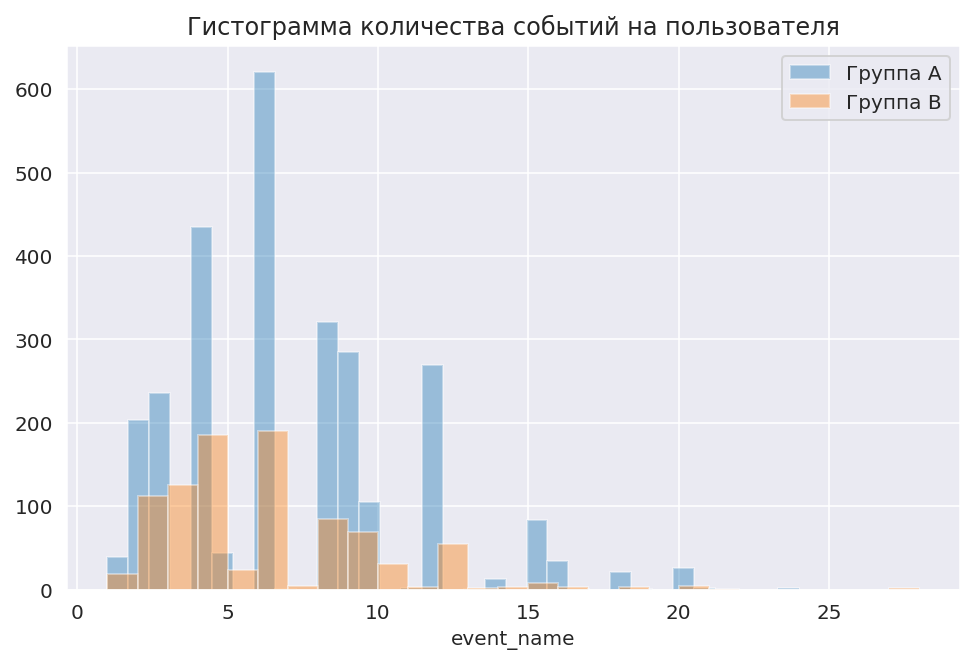

In [17]:
sns.set_style("darkgrid")

fig, ax = plt.subplots(figsize=(8,5))

sns.distplot(a_events.groupby('user_id')['event_name'].count(), kde=False, ax=ax)
sns.distplot(b_events.groupby('user_id')['event_name'].count(), kde=False, ax=ax)
ax.set_title("Гистограмма количества событий на пользователя")
ax.legend(labels=['Группа А', 'Группа В'])
  
plt.show()

Видим, что количество событий на пользователяв выборках распределены примерно одинаково.

Проверим, попали ли одни и те же пользователи в разные группы тестах:

In [18]:
groups_by_user_recom = recom_test_participants.groupby('user_id')['group'].count().reset_index()
print(len(groups_by_user_recom.query('group > 1')))

0


In [19]:
interface_test_participants = participants.query('ab_test == "interface_eu_test"')

groups_by_user_interface = interface_test_participants.groupby('user_id')['group'].count().reset_index()
print(len(groups_by_user_interface.query('group > 1')))

0


Отлично, внутри каждого теста пересечений по группам нет.

#### Изучение распределения количества событий по дням

[Вернуться в начало](#A/B-тестирование)

Создадим столбец с датой и посчитаем количество событий в день:

In [20]:
events['date'] = events['event_dt'].dt.date

events_by_date = events.groupby('date')['event_name'].count().reset_index()

Построим график:

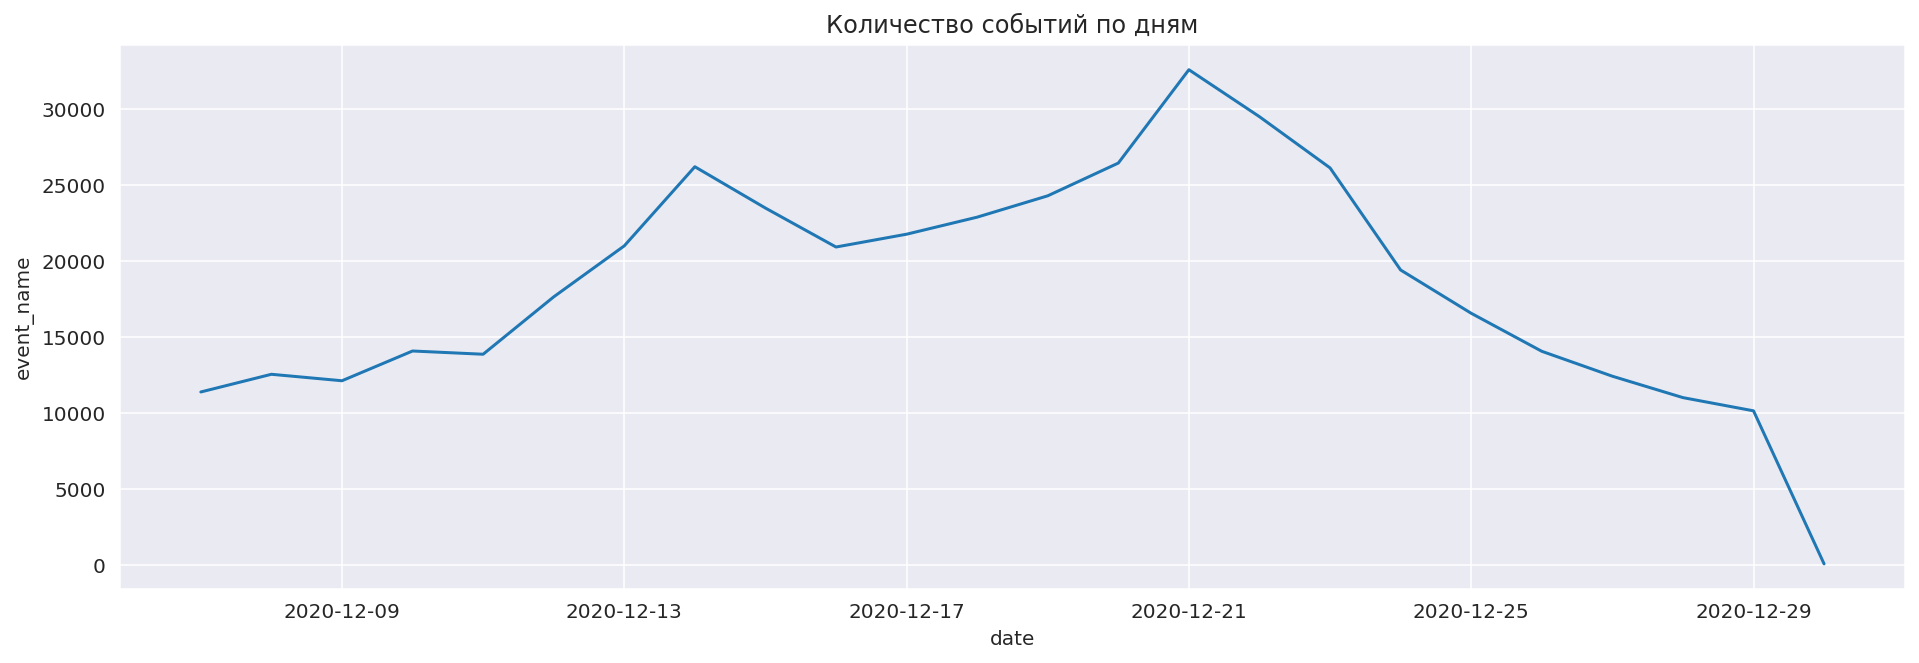

In [21]:
fig, ax = plt.subplots(figsize=(16,5))

sns.lineplot(data=events_by_date, x="date", y="event_name", ax=ax)
ax.set_title("Количество событий по дням")
  
plt.show()

Видим два ярко выраженных пика. Причиной тому может быть сезонность или пересечение с маркетинговыми событиями.

### Оценка корректности проведения теста

#### Проверка пересечения тестовой аудитории с конкурирующим тестом

[Вернуться в начало](#A/B-тестирование)

Узнаем, есть ли пересечения тестовой аудитории с конкурирующим тестом:

In [22]:
tests_by_user = participants.groupby('user_id')['ab_test'].nunique().reset_index()

print(len(tests_by_user.query('ab_test > 1')), 'пользователя участвовали в двух тестах')

1602 пользователя участвовали в двух тестах


Узнаем долю пересечений:

In [23]:
print('{:.2%}'.format(len(tests_by_user.query('ab_test > 1')) / participants['user_id'].nunique()))

9.61%


Почти 10% пользователей поучавствовали в двух тестах.

#### Проверка временных границ теста

[Вернуться в начало](#A/B-тестирование)

In [24]:
marketing

,name,regions,start_dt,finish_dt
0,Christmas&New Year Promo,"EU, N.America",2020-12-25,2021-01-03
1,St. Valentine's Day Giveaway,"EU, CIS, APAC, N.America",2020-02-14,2020-02-16
2,St. Patric's Day Promo,"EU, N.America",2020-03-17,2020-03-19
3,Easter Promo,"EU, CIS, APAC, N.America",2020-04-12,2020-04-19
4,4th of July Promo,N.America,2020-07-04,2020-07-11
5,Black Friday Ads Campaign,"EU, CIS, APAC, N.America",2020-11-26,2020-12-01
6,Chinese New Year Promo,APAC,2020-01-25,2020-02-07
7,Labor day (May 1st) Ads Campaign,"EU, CIS, APAC",2020-05-01,2020-05-03
8,International Women's Day Promo,"EU, CIS, APAC",2020-03-08,2020-03-10
9,Victory Day CIS (May 9th) Event,CIS,2020-05-09,2020-05-11


Найдем события для европейского региона:

In [25]:
marketing['split_regions'] = marketing['regions'].str.split(', ')

In [26]:
def is_eu(row):
    '''
    Функция проставляет флаг для европейского региона.
    '''
    res = 0
    for el in row['split_regions']:
        if el == 'EU': res += 1
    return res

In [27]:
marketing['is_na'] = marketing.apply(is_eu, axis=1)

eu_marketing = marketing.query('is_na == 1')
eu_marketing.sort_values('finish_dt', ascending=False) # сортировка для определения пересечений (наш тест в декабре)

,name,regions,start_dt,finish_dt,split_regions,is_na
0,Christmas&New Year Promo,"EU, N.America",2020-12-25,2021-01-03,"[EU, N.America]",1
5,Black Friday Ads Campaign,"EU, CIS, APAC, N.America",2020-11-26,2020-12-01,"[EU, CIS, APAC, N.America]",1
7,Labor day (May 1st) Ads Campaign,"EU, CIS, APAC",2020-05-01,2020-05-03,"[EU, CIS, APAC]",1
3,Easter Promo,"EU, CIS, APAC, N.America",2020-04-12,2020-04-19,"[EU, CIS, APAC, N.America]",1
2,St. Patric's Day Promo,"EU, N.America",2020-03-17,2020-03-19,"[EU, N.America]",1
8,International Women's Day Promo,"EU, CIS, APAC",2020-03-08,2020-03-10,"[EU, CIS, APAC]",1
1,St. Valentine's Day Giveaway,"EU, CIS, APAC, N.America",2020-02-14,2020-02-16,"[EU, CIS, APAC, N.America]",1


Согласно ТЗ, наш тест проходил с 7 декабря 2020 по 4 января 2021. С этими датами пересекается одномаркетинговое событие (`Christmas&New Year Promo`). Это недочет теста, так как маркетинговое событие повлияло на его результат.

#### Проверка аудитории теста

[Вернуться в начало](#A/B-тестирование)

In [28]:
eu_new_users = new_users.query('region == "EU"')
eu_new_users['first_date'].describe()

count                   46270
unique                     17
top       2020-12-21 00:00:00
freq                     4650
first     2020-12-07 00:00:00
last      2020-12-23 00:00:00
Name: first_date, dtype: object

Видим, что последняя дата для новых пользователей - 23 декабря, хотя по ТЗ должно быть 21.

Проверим соответствие аудитории теста 15% новых пользователей из европейского региона:

In [29]:
recom_test_participants['user_id'].nunique() / eu_new_users['user_id'].nunique()

0.144823859952453

Не 15, но очень близко.

Проверим равномерность распределения по тестовым группам:

In [30]:
recom_test_participants['group'].value_counts()

A    3824
B    2877
Name: group, dtype: int64

Видим, что группы распределены не равномерно.

### Анализ результатов теста

[Вернуться в начало](#A/B-тестирование)

In [31]:
funnel_a = funnel_a.set_index('event_name')
funnel_a

,user_id,event_conversion
event_name,,
login,2747,1.000000
product_page,1780,0.647980
purchase,872,0.489888
product_cart,824,0.944954


In [32]:
funnel_b = funnel_b.set_index('event_name')
funnel_b

,user_id,event_conversion
event_name,,
login,928,1.000000
product_page,523,0.563578
purchase,256,0.489484
product_cart,255,0.996094


Зададим критический уровень статистической значимости, равный 0,05 и проверим статистическую разницу долей z-критерием:

In [33]:
funnel_a.index

Index(['login', 'product_page', 'purchase', 'product_cart'], dtype='object', name='event_name')

In [34]:
alpha = 0.05

for event in ['product_page', 'purchase', 'product_cart']:
    current = np.array([funnel_a.loc[event, 'user_id'], funnel_b.loc[event, 'user_id']])
    total = np.array([funnel_a.loc['login', 'user_id'], funnel_b.loc['login', 'user_id']]) # за тотал берем значение из воронки,
                                                                                           # соответствующее логину
    # доли в группах:
    p1 = current[0]/total[0]
    p2 = current[1]/total[1]
    
    # доля в комбинированном датасете:
    p_combined = (current[0] + current[1]) / (total[0] + total[1])
    
    # разница долей в датасетах
    difference = p1 - p2 
        
    # считаем статистику в ст.отклонениях стандартного нормального распределения
    z_value = difference / mth.sqrt(p_combined * (1 - p_combined) * (1/total[0] + 1/total[1]))
        
    # задаем стандартное нормальное распределение (среднее 0, ст.отклонение 1)
    distr = st.norm(0, 1) 
        
    p_value = (1 - distr.cdf(abs(z_value))) * 2
    
    print('\033[1m' + 'Событие:', event,'\n' + '\033[0;0m')
    print('Доля для группы A:', current[0],'из',total[0])
    print('Доля для группы B:', current[1],'из',total[1])
    print('\np_value:', p_value)
        
    if (p_value < alpha):
        display(HTML("<font color='red'>Отвергаем нулевую гипотезу: между долями есть значимая разница</font>"))
    else:
        display(HTML("<font color='green'>Не получилось отвергнуть нулевую гипотезу,\
                                            нет оснований считать доли разными</font>"))

Событие: product_page 

Доля для группы A: 1780 из 2747
Доля для группы B: 523 из 928

p_value: 4.310980554755872e-06


Событие: purchase 

Доля для группы A: 872 из 2747
Доля для группы B: 256 из 928

p_value: 0.017592402663314743


Событие: product_cart 

Доля для группы A: 824 из 2747
Доля для группы B: 255 из 928

p_value: 0.14534814557238196


Видим, что для событий *страница карточек продукта и покупка* между долями есть значимая разница, в то время, как для *просмотра корзины* нет.

### Выводы

[Вернуться в начало](#A/B-тестирование)

В ходе выполнения проекта в проведенном тесте были обнаружены следующие **недочеты**:
- тест остановлен на 5 дней раньше, чем нужно;
- 1602 пользователя (9,61%) участвовали в двух тестах;
- с тестом пересекается маркетинговое событие (Christmas&New Year Promo), что могло повлиять на его результат;
- последняя дата для новых пользователей - 23 декабря, хотя по ТЗ должно быть 21;
- группы в тесте распределены не равномерно.

Итог: *тест проведен некорректно.*

При таких данных тест показал, что для конверсии в просмотр карточек товаров и покупки между долями есть значимая разница, в то время, как для просмотра корзины нет.

Тест следует провести заново, уитывая приведенные выше замечания.